In [504]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import math


In [758]:
def seq2seq(feature_len, after_day, input_shape):

    # Encoder
    encoder_inputs = Input(shape=input_shape) # (timesteps, feature)
    encoder = LSTM(units=512, return_state=True,  name='encoder')
    #model.add(Dropout(0.5)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]

    # Decoder
    reshapor = Reshape((1, 512), name='reshapor')
    decoder = LSTM(units=512, return_sequences=True, return_state=True, name='decoder')
    #model.add(Dropout(0.5)
    # Densor
    #tdensor = TimeDistributed(Dense(units=200, activation='linear', name='time_densor'))
    densor_output = Dense(units=feature_len, activation='relu', name='output')

    inputs = reshapor(encoder_outputs)
    #inputs = tdensor(inputs)
    all_outputs = []

    for _ in range(after_day):
        outputs, h, c = decoder(inputs, initial_state=states)

        #inputs = tdensor(outputs)
        inputs = outputs
        states = [state_h, state_c]

        outputs = densor_output(outputs)
        all_outputs.append(outputs)

    decoder_outputs = Lambda(lambda x: backend.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

    return model

In [507]:
def normalize_data(data, scaler):
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)

    return normalize_data
def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data

def normalize(df):
    min_max_scaler = MinMaxScaler()
    #df = df.drop(['date','adj_close'],axis=1)
    for col in df.columns: 
        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))
    return df
def denormalize(normalized,original,feature='close'):
    original_value = original[feature].values.reshape(-1,1)
    normalized_value = normalized.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    return min_max_scaler.inverse_transform(normalized_value)[:,0]

In [657]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def buildTrain(train, pastDay=30, futureDay=5,feature='close',drop=False):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
        Y_train.append(np.array(train[i+pastDay:i+pastDay+futureDay]))
        #Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay][feature]))        
    return np.array(X_train), np.array(Y_train)

def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
def plot_predict(actual, predict,feature=15,shift=True):
    #file_path = 'images/result/{}.png'.format(file_name)

    fig = plt.figure(figsize=(15, 10))
    days = predict.shape[1]
    row_num = math.ceil(days/3)*100
    
    for i in range(days):
        ax = fig.add_subplot(row_num+31+i)
        if shift:
            ax.plot(actual[:,0,feature],label='actual',color='red')
        else:
            ax.plot(actual[:,i,feature],label='actual',color='red')
        ax.plot(predict[:,i,feature],label='predict',color='blue')
        if shift:
            ax.title.set_text(f'shift {i+1} Day')
        else:
            ax.title.set_text(f'Day {i+1}')
        ax.legend(loc='best')

In [682]:
scaler = MinMaxScaler(feature_range=(0, 1))
validate_percent = 0.2
time_step = 30
after_day = 7
batch_size = 64
epochs = 100
val_ratio = 0.33

In [683]:
#df = []
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
'''
all_df=[]
for train_data in os.listdir(os.path.join(os.getcwd(),'data')):
    with open(os.path.join(os.getcwd(),"data",train_data),'rb') as f:
        print(train_data)
        
        sub_df=pickle.load(f)#.iloc[:-60]
        #all_df.append(sub_df)
'''

        


#df = pd.concat(all_df,axis=0, ignore_index=True)

#df.shape

'\nall_df=[]\nfor train_data in os.listdir(os.path.join(os.getcwd(),\'data\')):\n    with open(os.path.join(os.getcwd(),"data",train_data),\'rb\') as f:\n        print(train_data)\n        \n        sub_df=pickle.load(f)#.iloc[:-60]\n        #all_df.append(sub_df)\n'

In [759]:
scaler = MinMaxScaler(feature_range=(0, 1))
time_step = 60
after_day = 7
batch_size = 64
epochs = 1000
val_ratio = 0.2
#sub_df = df[['high','close','low','open']]
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
#sub_df = df.iloc[:-60]
df.drop(['year','week','month','day','adj_close'],axis=1,inplace=True)
test_df = df[-60:]
sub_df = df[:-60]
data = normalize_data(sub_df.copy(), scaler)

In [760]:
x_train,y_train=buildTrain(data, time_step,after_day,drop=False)
x_train, y_train = shuffle(x_train, y_train)
X_train, Y_train, X_val, Y_val = splitData(x_train, y_train, val_ratio)

In [761]:
feature_len = X_train.shape[2]
input_shape = (time_step, feature_len)
model = seq2seq(feature_len, after_day, input_shape)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 60, 24)]     0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 512), (None, 1099776     input_56[0][0]                   
__________________________________________________________________________________________________
reshapor (Reshape)              (None, 1, 512)       0           encoder[0][0]                    
__________________________________________________________________________________________________
decoder (LSTM)                  [(None, 1, 512), (No 2099200     reshapor[0][0]                   
                                                                 encoder[0][1]             

In [762]:
callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=1000, validation_data=(X_val, Y_val), callbacks=[callback])

Epoch 1/1000
41/41 [==============================] - 52s 1s/step - loss: 0.1037 - accuracy: 0.2106 - val_loss: 0.0719 - val_accuracy: 0.3232
Epoch 2/1000
41/41 [==============================] - 19s 464ms/step - loss: 0.0689 - accuracy: 0.3659 - val_loss: 0.0683 - val_accuracy: 0.3655
Epoch 3/1000
41/41 [==============================] - 18s 437ms/step - loss: 0.0670 - accuracy: 0.3713 - val_loss: 0.0690 - val_accuracy: 0.3651
Epoch 4/1000
41/41 [==============================] - 18s 446ms/step - loss: 0.0664 - accuracy: 0.4017 - val_loss: 0.0682 - val_accuracy: 0.3867
Epoch 5/1000
41/41 [==============================] - 18s 435ms/step - loss: 0.0651 - accuracy: 0.4040 - val_loss: 0.0661 - val_accuracy: 0.4074
Epoch 6/1000
41/41 [==============================] - 18s 438ms/step - loss: 0.0648 - accuracy: 0.4049 - val_loss: 0.0668 - val_accuracy: 0.3710
Epoch 7/1000
41/41 [==============================] - 18s 438ms/step - loss: 0.0637 - accuracy: 0.4167 - val_loss: 0.0663 - val_accur

41/41 [==============================] - 18s 432ms/step - loss: 0.0360 - accuracy: 0.4815 - val_loss: 0.0367 - val_accuracy: 0.4680
Epoch 58/1000
41/41 [==============================] - 18s 434ms/step - loss: 0.0358 - accuracy: 0.4903 - val_loss: 0.0370 - val_accuracy: 0.4914
Epoch 59/1000
41/41 [==============================] - 18s 429ms/step - loss: 0.0352 - accuracy: 0.4944 - val_loss: 0.0364 - val_accuracy: 0.4944
Epoch 60/1000
41/41 [==============================] - 18s 436ms/step - loss: 0.0353 - accuracy: 0.4936 - val_loss: 0.0358 - val_accuracy: 0.4868
Epoch 61/1000
41/41 [==============================] - 18s 437ms/step - loss: 0.0350 - accuracy: 0.4960 - val_loss: 0.0368 - val_accuracy: 0.5040
Epoch 62/1000
41/41 [==============================] - 18s 433ms/step - loss: 0.0351 - accuracy: 0.4965 - val_loss: 0.0363 - val_accuracy: 0.4855
Epoch 63/1000
41/41 [==============================] - 18s 436ms/step - loss: 0.0348 - accuracy: 0.4992 - val_loss: 0.0357 - val_accuracy:

41/41 [==============================] - 18s 432ms/step - loss: 0.0250 - accuracy: 0.6200 - val_loss: 0.0272 - val_accuracy: 0.6150
Epoch 114/1000
41/41 [==============================] - 18s 433ms/step - loss: 0.0250 - accuracy: 0.6250 - val_loss: 0.0263 - val_accuracy: 0.6198
Epoch 115/1000
41/41 [==============================] - 18s 434ms/step - loss: 0.0248 - accuracy: 0.6279 - val_loss: 0.0260 - val_accuracy: 0.6092
Epoch 116/1000
41/41 [==============================] - 18s 433ms/step - loss: 0.0250 - accuracy: 0.6269 - val_loss: 0.0264 - val_accuracy: 0.6222
Epoch 117/1000
41/41 [==============================] - 18s 434ms/step - loss: 0.0248 - accuracy: 0.6292 - val_loss: 0.0261 - val_accuracy: 0.6244
Epoch 118/1000
41/41 [==============================] - 18s 435ms/step - loss: 0.0245 - accuracy: 0.6302 - val_loss: 0.0261 - val_accuracy: 0.6270
Epoch 119/1000
41/41 [==============================] - 18s 434ms/step - loss: 0.0243 - accuracy: 0.6291 - val_loss: 0.0260 - val_acc

Epoch 169/1000
41/41 [==============================] - 18s 433ms/step - loss: 0.0196 - accuracy: 0.7095 - val_loss: 0.0229 - val_accuracy: 0.6696
Epoch 170/1000
41/41 [==============================] - 18s 441ms/step - loss: 0.0197 - accuracy: 0.7081 - val_loss: 0.0228 - val_accuracy: 0.6796
Epoch 171/1000
41/41 [==============================] - 18s 435ms/step - loss: 0.0195 - accuracy: 0.7099 - val_loss: 0.0229 - val_accuracy: 0.6680
Epoch 172/1000
41/41 [==============================] - 18s 435ms/step - loss: 0.0193 - accuracy: 0.7090 - val_loss: 0.0226 - val_accuracy: 0.6761
Epoch 173/1000
41/41 [==============================] - 18s 433ms/step - loss: 0.0191 - accuracy: 0.7155 - val_loss: 0.0230 - val_accuracy: 0.6737
Epoch 174/1000
41/41 [==============================] - 18s 434ms/step - loss: 0.0193 - accuracy: 0.7164 - val_loss: 0.0232 - val_accuracy: 0.6694
Epoch 175/1000
41/41 [==============================] - 18s 434ms/step - loss: 0.0190 - accuracy: 0.7167 - val_loss: 0

Epoch 225/1000
41/41 [==============================] - 18s 432ms/step - loss: 0.0132 - accuracy: 0.8132 - val_loss: 0.0198 - val_accuracy: 0.7228
Epoch 226/1000
41/41 [==============================] - 18s 437ms/step - loss: 0.0132 - accuracy: 0.8154 - val_loss: 0.0202 - val_accuracy: 0.7182
Epoch 227/1000
41/41 [==============================] - 18s 431ms/step - loss: 0.0136 - accuracy: 0.8119 - val_loss: 0.0201 - val_accuracy: 0.7256
Epoch 228/1000
41/41 [==============================] - 18s 435ms/step - loss: 0.0133 - accuracy: 0.8155 - val_loss: 0.0201 - val_accuracy: 0.7328
Epoch 229/1000
41/41 [==============================] - 18s 432ms/step - loss: 0.0131 - accuracy: 0.8186 - val_loss: 0.0203 - val_accuracy: 0.7206
Epoch 230/1000
41/41 [==============================] - 18s 431ms/step - loss: 0.0132 - accuracy: 0.8198 - val_loss: 0.0198 - val_accuracy: 0.7228
Epoch 231/1000
41/41 [==============================] - 18s 435ms/step - loss: 0.0128 - accuracy: 0.8182 - val_loss: 0

Epoch 281/1000
41/41 [==============================] - 18s 434ms/step - loss: 0.0082 - accuracy: 0.9049 - val_loss: 0.0178 - val_accuracy: 0.7625
Epoch 282/1000
41/41 [==============================] - 18s 437ms/step - loss: 0.0082 - accuracy: 0.9068 - val_loss: 0.0175 - val_accuracy: 0.7590
Epoch 283/1000
41/41 [==============================] - 18s 434ms/step - loss: 0.0081 - accuracy: 0.9067 - val_loss: 0.0173 - val_accuracy: 0.7647
Epoch 284/1000
41/41 [==============================] - 18s 433ms/step - loss: 0.0079 - accuracy: 0.9096 - val_loss: 0.0172 - val_accuracy: 0.7625
Epoch 285/1000
41/41 [==============================] - 18s 441ms/step - loss: 0.0080 - accuracy: 0.9093 - val_loss: 0.0172 - val_accuracy: 0.7644
Epoch 286/1000
41/41 [==============================] - 18s 433ms/step - loss: 0.0079 - accuracy: 0.9080 - val_loss: 0.0168 - val_accuracy: 0.7616
Epoch 287/1000
41/41 [==============================] - 18s 431ms/step - loss: 0.0075 - accuracy: 0.9144 - val_loss: 0

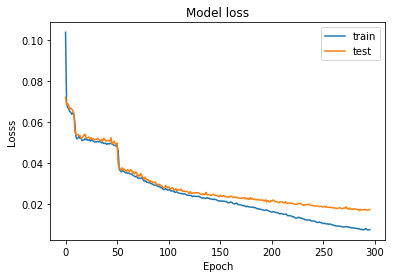

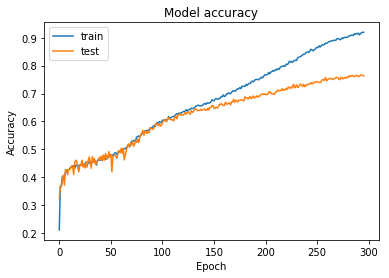

In [763]:
training_result(history)

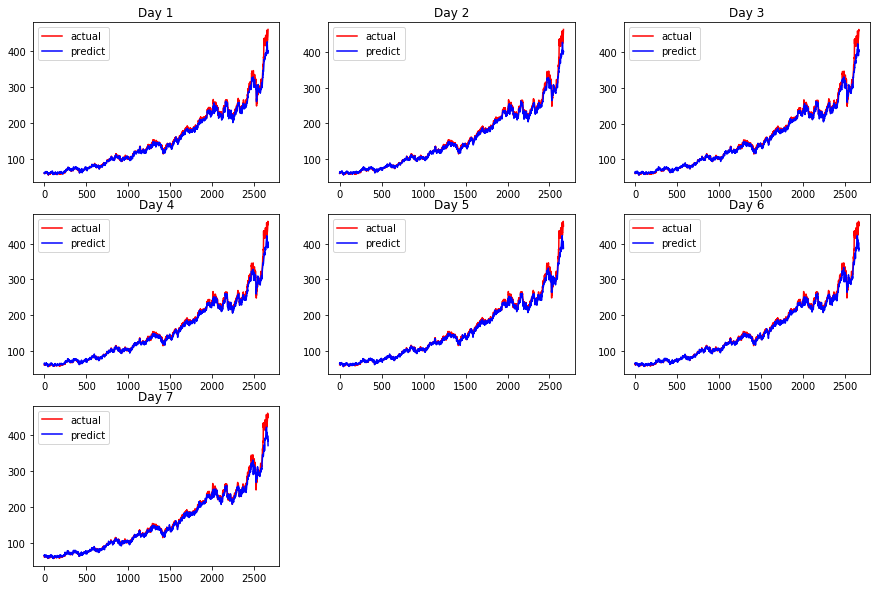

In [764]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
df.drop(['year','week','month','day','adj_close'],axis=1,inplace=True)
data = normalize_data(df.copy(), scaler)
x_train,y_train=buildTrain(data, time_step,after_day,drop=False)
X_train, Y_train, X_val, Y_val = splitData(x_train, y_train, val_ratio)
#scaler = MinMaxScaler(feature_range=(0, 1))
#normalize_data(df.drop(['year','week','month','day','adj_close'],axis=1), scaler)
#x_train,y_train=buildTrain(sub_df.copy(), time_step,after_day,drop=False)
#_, _, _, Y_val = splitData(x_train, y_train, val_ratio)
train_predict = model.predict(X_train.copy())
#print(train_predict.shape)
result = inverse_normalize_data(train_predict.copy(), scaler)

actual = inverse_normalize_data(Y_train.copy(), scaler)
#actual = inverse_normalize_data(Y_val, scaler)
plot_predict(actual, result,shift=False)

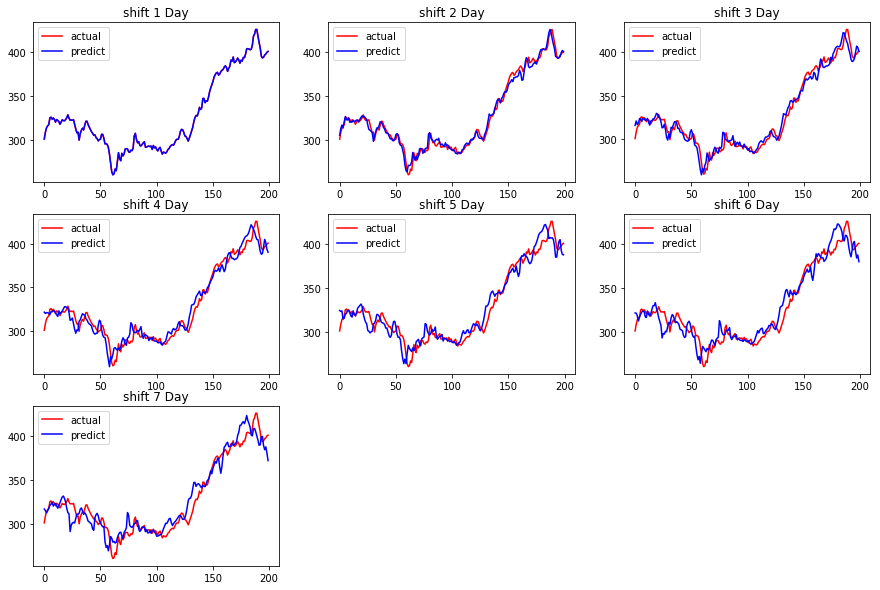

In [767]:
plot_predict(result[-200:], result[-200:])

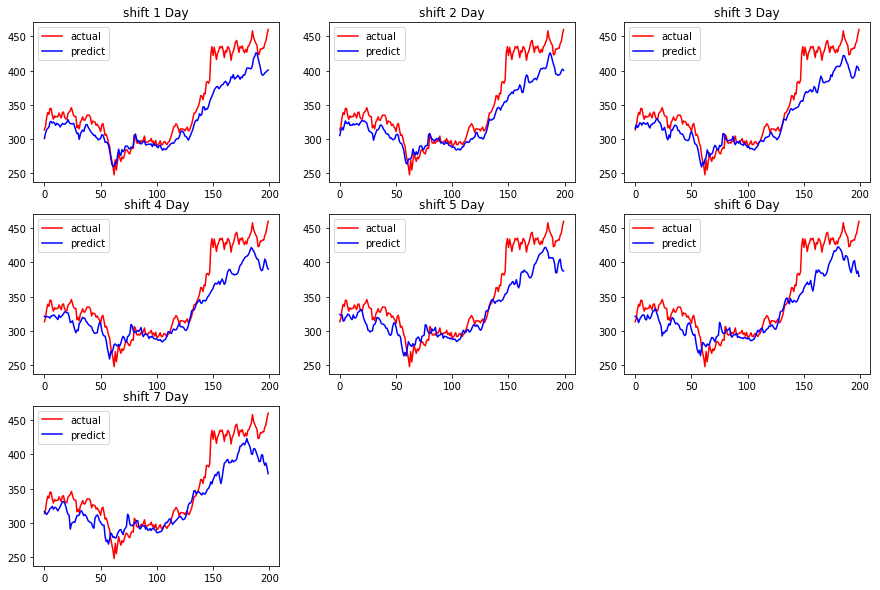

In [766]:
plot_predict(actual[-200:], result[-200:])